In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('train.csv')
print(df.shape)

test = pd.read_csv('test.csv')
print(test.shape)


##分開x(features) y(class), 數值型標準化, 非數值型處理(t/f, 類別etc)處理成one hot 0 or 1, 處理缺失值
##缺失值:數值型先用median, 類別型用最常出現的來補
##只有['flbmk', 'flg_3dsmk']有缺失值
##用(locdt, loctm)來排序

##只有1.3%有盜刷
##lift chart, roc可拿來評估
##test data沒答案沒辦法用
##train data有時序性，拿來test的一定要在train的後面(locdt, loctm)才合理
##可以自己評估成效如何並說明為何要用，不一定要用f1 score


(1521787, 23)
(421665, 22)


In [2]:
df_train = df.set_index('txkey')
df_train.sort_values(by=['locdt', 'loctm'], inplace=True)
##根據時序性排序?
train_y = df_train[['fraud_ind']]
train_x = df_train.drop('fraud_ind', 1)

test_x = test.set_index('txkey')
test_y = pd.read_csv('y_test.csv').set_index('txkey')
##test data 的答案跟test_x對不上, 這個test_y是從原來train_y分出來的四分之一

print(train_x.keys())
print(test_x.columns)
# display(df.isnull().sum())
# display(test.isnull().sum())

#前處理要把test_x一起放進去處理不然label encoding會漏植
all_x = pd.concat((train_x,test_x),0)


print(df_train.shape,train_x.shape,train_y.shape,test_x.shape,all_x.shape)

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'locdt', 'loctm',
       'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd'],
      dtype='object')
Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'locdt', 'loctm',
       'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd'],
      dtype='object')
(1521787, 22) (1521787, 21) (1521787, 1) (421665, 21) (1943452, 21)


In [3]:
col_names_cont = [] # 數值型資料
col_names_disc = [] # 類別型資料
col_has_na = [] # 待補NA資料
for c in all_x.keys():
    uni = all_x[c].unique()
    n_na = pd.isna(all_x[c]).sum() # NA 數量
    if n_na > 0:
        col_has_na.append(c)       
    if len(uni) < 200 :
        print(f"{c}: uni={uni}")
        col_names_disc.append(c)
    else:
        info = [ all_x[c].max(), all_x[c].min(), all_x[c].mean(), all_x[c].std()]
        info = [ round(x,2) for x in info ]
        offset = 1 if n_na else 0
        diversity = (len(uni)-offset)/(len(all_x)-n_na)
        print(f"{c}: dtype={all_x[c].dtype}, n_na={n_na}")
        print("       max={}, min={}, mean={}, std={}, diversity={:.2f}%".format(*info, diversity*100 ) )
        if diversity == 1.0:
            print(f"       Delete col [{c}] due to diversity is 100% ")
        else:
            col_names_cont.append(c)

acqic: dtype=int64, n_na=0
       max=6884, min=0, mean=6004.54, std=1505.74, diversity=0.35%
bacno: dtype=int64, n_na=0
       max=163886, min=0, mean=82087.41, std=47323.48, diversity=8.40%
cano: dtype=int64, n_na=0
       max=213575, min=0, mean=109045.28, std=61103.56, diversity=10.93%
conam: dtype=float64, n_na=0
       max=7208.77, min=0.0, mean=651.62, std=403.22, diversity=4.44%
contp: uni=[4 5 2 3 6 1 0]
csmcu: uni=[62 60  0 61 13 71 75 40 53 26 73 17 54 66  4 10 23 52 20 44 35 56 38 50
 29 31 37 30 32 49 18 45 68 74  7 24 51 21 41 47 39  6 22 67 42 11 12 15
 59  3 46  5 57 27  2 28 48 14 16 64 25 70 72  1 63 34 43  9 36 55 69 19
  8 33 65 58]
ecfg: uni=['N' 'Y']
etymd: uni=[ 2  8  5  0  4  1  6  9  3  7 10]
flbmk: uni=['N' nan 'Y']
flg_3dsmk: uni=['N' 'Y' nan]
hcefg: uni=[5 1 6 2 8 0 7 9 3 4]
insfg: uni=['Y' 'N']
iterm: uni=[2 0 1 7 4 3 8 5 6]
locdt: uni=[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  

In [4]:
##fill nan by mode
print((all_x['flbmk']=='Y').sum())
print((all_x['flg_3dsmk']=='Y').sum())
##Y都占很少比例所以可以用N來補缺值
print(col_has_na)
# all_x['flbmk'].fillna(all_x['flbmk'].mode().values[0], inplace=True)
# all_x['flg_3dsmk'].fillna(all_x['flg_3dsmk'].mode().values[0], inplace=True)
all_x['flbmk'].fillna('NA', inplace=True)
all_x['flg_3dsmk'].fillna('NA', inplace=True)

6395
84533
['flbmk', 'flg_3dsmk']


In [5]:
##數值
df_cont = all_x[col_names_cont].copy()
print(df_cont.shape)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_cont = scaler.fit_transform(df_cont)
df_cont = pd.DataFrame(data=X_cont, index=all_x.index, columns=col_names_cont)
df_cont.head()

(1943452, 8)


,acqic,bacno,cano,conam,loctm,mcc,mchno,scity
txkey,,,,,,,,
1119159,0.472498,-1.464863,-0.123254,0.781122,-2.792234,-0.649316,-0.679328,0.536031
641444,-0.285272,-0.998456,-0.788437,1.040337,-2.792024,-1.210458,-0.716792,-1.319846
188670,0.507697,-1.256404,0.025002,-0.529260,-2.791928,-0.598303,0.757870,-0.588392
1475737,0.506368,0.200758,1.635187,1.295955,-2.791871,-0.062667,-1.334027,0.536031
641443,-1.863903,0.043543,1.162907,-0.705145,-2.791814,-0.598303,0.424066,-0.389638


In [6]:
##類別
df_disc = all_x[col_names_disc].copy()
display(df_disc.head())
from sklearn.preprocessing import LabelEncoder
les = {}
for c in col_names_disc:
    le = LabelEncoder()
    df_disc.loc[:,c] = le.fit_transform(df_disc.loc[:,c])
    les.update({c:le})
df_disc.head()

,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,ovrlt,stocn,stscd
txkey,,,,,,,,,,,,,
1119159,4,62,N,2,N,N,5,Y,2,1,N,102,0
641444,5,62,Y,8,N,N,5,N,0,1,N,44,0
188670,5,62,N,5,N,N,5,N,0,1,N,102,0
1475737,5,62,N,5,N,N,5,N,0,1,N,102,0
641443,5,60,N,5,N,N,5,N,0,1,N,38,0


,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,ovrlt,stocn,stscd
txkey,,,,,,,,,,,,,
1119159,4,62,0,2,0,0,5,1,2,0,0,102,0
641444,5,62,1,8,0,0,5,0,0,0,0,44,0
188670,5,62,0,5,0,0,5,0,0,0,0,102,0
1475737,5,62,0,5,0,0,5,0,0,0,0,102,0
641443,5,60,0,5,0,0,5,0,0,0,0,38,0


In [7]:
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(sparse=False)
# X_disc = ohe.fit_transform(df_disc)

# new_col_names_disc = []
# for c in col_names_disc: 
#     le = les[c]
#     new_col_names_disc += [ c+'_'+str(cl) for cl in le.classes_ ]
# assert len(new_col_names_disc) == X_disc.shape[1]
# df_disc = pd.DataFrame(data=X_disc, index=all_x.index, columns=new_col_names_disc)
# df_disc.head()

,contp_0,contp_1,contp_2,contp_3,contp_4,contp_5,contp_6,csmcu_0,csmcu_1,csmcu_2,...,stocn_104,stocn_105,stocn_106,stocn_107,stocn_108,stscd_0,stscd_1,stscd_2,stscd_3,stscd_4
txkey,,,,,,,,,,,,,,,,,,,,,
1119159,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
641444,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
188670,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1475737,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
641443,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
all_x_preprocessed = pd.concat((df_cont, df_disc), 1)
print(all_x_preprocessed.shape)
all_x_preprocessed.head()

(1943452, 21)


,acqic,bacno,cano,conam,loctm,mcc,mchno,scity,contp,csmcu,...,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,ovrlt,stocn,stscd
txkey,,,,,,,,,,,,,,,,,,,,,
1119159,0.472498,-1.464863,-0.123254,0.781122,-2.792234,-0.649316,-0.679328,0.536031,4,62,...,2,0,0,5,1,2,0,0,102,0
641444,-0.285272,-0.998456,-0.788437,1.040337,-2.792024,-1.210458,-0.716792,-1.319846,5,62,...,8,0,0,5,0,0,0,0,44,0
188670,0.507697,-1.256404,0.025002,-0.529260,-2.791928,-0.598303,0.757870,-0.588392,5,62,...,5,0,0,5,0,0,0,0,102,0
1475737,0.506368,0.200758,1.635187,1.295955,-2.791871,-0.062667,-1.334027,0.536031,5,62,...,5,0,0,5,0,0,0,0,102,0
641443,-1.863903,0.043543,1.162907,-0.705145,-2.791814,-0.598303,0.424066,-0.389638,5,60,...,5,0,0,5,0,0,0,0,38,0


In [8]:
train_x = all_x_preprocessed.loc[train_x.index]
print(train_x.shape)


(1521787, 21)


In [9]:
test_x = all_x_preprocessed.loc[test_x.index]
print(test_x.shape)
test_x.head()

(421665, 21)


,acqic,bacno,cano,conam,loctm,mcc,mchno,scity,contp,csmcu,...,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,ovrlt,stocn,stscd
txkey,,,,,,,,,,,,,,,,,,,,,
592489,0.582079,1.71375,0.126895,-0.341794,1.325983,2.028863,0.11248,-2.398364,5,0,...,0,0,0,5,0,0,101,0,102,0
592452,0.582079,1.71375,0.126895,-0.341794,1.453738,2.028863,0.11248,-2.398364,5,0,...,0,0,0,5,0,0,101,0,102,0
590212,0.582079,1.71375,0.126895,-0.341794,0.459202,2.028863,0.11248,-2.398364,5,0,...,0,0,0,5,0,0,99,0,102,0
590209,0.582079,1.71375,0.126895,-0.341794,0.380797,2.028863,0.11248,-2.398364,5,0,...,0,0,0,5,0,0,99,0,102,0
592488,0.582079,1.71375,0.126895,-0.341794,1.325658,2.028863,0.11248,-2.398364,5,0,...,0,0,0,5,0,0,101,0,102,0


In [66]:
##calculate Pearson correlation
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.concat((train_x,train_y),1)
data.head()
data.corr()['fraud_ind'].sort_values(ascending=False)

# plt.figure(figsize=(20,20))
# sns.heatmap(data.corr(), annot=True)
# plt.show()

index_cor = data.columns[data.corr()['fraud_ind'].abs()>0.025].drop('fraud_ind')
data.corr()['fraud_ind'].abs().sort_values(ascending=False)

fraud_ind    1.000000
stscd        0.279225
ecfg         0.161701
stocn        0.161405
stocn_k      0.148973
acqic        0.083684
etymd_k      0.075384
etymd        0.067743
loctm_k      0.063976
acqic_k      0.055927
loctm        0.042688
scity        0.028715
hcefg_k      0.028114
hcefg        0.026210
contp        0.023248
flg_3dsmk    0.020809
insfg        0.018403
ovrlt        0.018177
conam        0.016634
iterm        0.014662
csmcu        0.013472
mchno        0.012187
locdt        0.011773
conam_k      0.009801
scity_k      0.007335
cano         0.004608
mcc          0.002827
flbmk        0.002543
bacno        0.000285
Name: fraud_ind, dtype: float64

[0.7077297195047547, 0.4913881400098294, 0.37542700429418796, 0.2829809084911051, 0.21844767312911478, 0.19043085808941362, 0.17785474022480596, 0.1476924194106518, 0.1347119223563701]


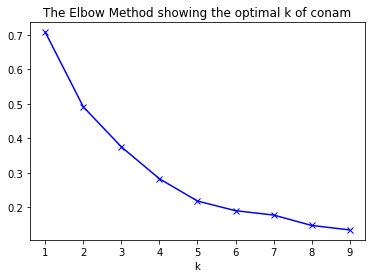

In [42]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

col = ['conam']

feat_dict={}
for c in col:
    df = train_x[c]
    distortions = []
    for k in range(1, 10):
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df.values.reshape(-1,1))
        distortions.append(sum(np.min(cdist(df.values.reshape(-1,1), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

    print(distortions)
    plt.plot(range(1, 10), distortions, 'bx-')
    plt.xlabel('k')
    #plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k of '+ c)
    plt.show()

In [43]:
##ecfg只有0or1, 'stscd'只有0-4
df.shape[0]
col = ['conam','acqic', 'loctm', 'scity', 'etymd', 'hcefg', 'stocn']
k_list=[5,4,4,3,5,2,2]
feat_dict={}
for i,c in enumerate(col):
    feat_dict[c]=k_list[i]
    df = train_x[c]
    clf = KMeans(n_clusters=feat_dict[c])

    #開始訓練！
    clf.fit(df.values.reshape(-1,1))

    #這樣就可以取得預測結果了！
    label = clf.predict(df.values.reshape(-1,1))


    train_x[c+'_k'] = pd.Series(label, index=train_x.index)
    break

train_x



,acqic,bacno,cano,conam,loctm,mcc,mchno,scity,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,ovrlt,stocn,stscd,acqic_k,loctm_k,scity_k,etymd_k,hcefg_k,stocn_k,conam_k
txkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1119159,0.472498,-1.464863,-0.123254,0.781122,-2.792234,-0.649316,-0.679328,0.536031,4,62,0,2,0,0,5,1,2,0,0,102,0,0,3,1,3,0,0,0
641444,-0.285272,-0.998456,-0.788437,1.040337,-2.792024,-1.210458,-0.716792,-1.319846,5,62,1,8,0,0,5,0,0,0,0,44,0,3,3,0,0,0,1,4
188670,0.507697,-1.256404,0.025002,-0.529260,-2.791928,-0.598303,0.757870,-0.588392,5,62,0,5,0,0,5,0,0,0,0,102,0,0,3,0,4,0,0,3
1475737,0.506368,0.200758,1.635187,1.295955,-2.791871,-0.062667,-1.334027,0.536031,5,62,0,5,0,0,5,0,0,0,0,102,0,0,3,1,4,0,0,4
641443,-1.863903,0.043543,1.162907,-0.705145,-2.791814,-0.598303,0.424066,-0.389638,5,60,0,5,0,0,5,0,0,0,0,38,0,2,3,0,4,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325840,0.018235,-1.595095,1.361880,-0.061226,1.719788,-0.636563,0.937730,0.536031,5,62,1,2,0,0,5,0,0,89,0,102,0,3,2,1,3,0,0,3
784237,-0.188973,1.494134,0.687435,-0.904219,1.719903,-0.037161,0.380179,0.506268,5,62,1,8,0,0,5,0,0,89,0,92,0,3,2,1,0,0,0,1
1459862,0.513010,-1.664362,1.017678,-0.065144,1.720496,-0.521784,-1.729526,0.536031,5,62,1,8,0,0,5,0,0,89,1,102,0,0,2,1,0,0,0,3


In [78]:
choose_col = ['loctm_k', 'etymd_k', 'hcefg_k', 'stocn', 'ecfg', 'stscd','conam_k']
none_choose_col = ['contp', 'csmcu', 'flbmk', 'flg_3dsmk', 'insfg', 'iterm', 'locdt', 'mcc', 'mchno', 'ovrlt']

train_x
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
X_disc = ohe.fit_transform(train_x[choose_col])

new_col_names = []
for c in choose_col: 
    #le = les[c]
    new_col_names += [ c+'_'+str(cl) for cl in train_x[c].unique() ]
assert len(new_col_names) == X_disc.shape[1]
df = pd.DataFrame(data=X_disc, index=train_x.index, columns=new_col_names)
df

,loctm_k_3,loctm_k_0,loctm_k_1,loctm_k_2,etymd_k_3,etymd_k_0,etymd_k_4,etymd_k_2,etymd_k_1,hcefg_k_0,hcefg_k_1,stocn_102,stocn_44,stocn_38,stocn_98,stocn_32,stocn_20,stocn_46,stocn_16,stocn_104,stocn_52,stocn_93,stocn_25,stocn_75,stocn_5,stocn_27,stocn_10,stocn_36,stocn_92,stocn_85,stocn_42,stocn_17,stocn_26,stocn_89,stocn_6,stocn_48,stocn_61,stocn_68,stocn_81,stocn_62,stocn_72,stocn_2,stocn_73,stocn_55,stocn_78,stocn_95,stocn_106,stocn_41,stocn_1,stocn_77,...,stocn_60,stocn_70,stocn_31,stocn_47,stocn_88,stocn_30,stocn_54,stocn_67,stocn_7,stocn_96,stocn_35,stocn_15,stocn_65,stocn_4,stocn_22,stocn_19,stocn_39,stocn_63,stocn_57,stocn_99,stocn_51,stocn_79,stocn_86,stocn_11,stocn_53,stocn_91,stocn_43,stocn_8,stocn_59,stocn_64,stocn_97,stocn_3,stocn_82,stocn_12,stocn_29,stocn_24,stocn_100,stocn_33,ecfg_0,ecfg_1,stscd_0,stscd_2,stscd_3,stscd_1,stscd_4,conam_k_0,conam_k_4,conam_k_3,conam_k_2,conam_k_1
txkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1119159,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
641444,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
188670,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1475737,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
641443,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325840,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
784237,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [79]:
# stscd        0.279225
# ecfg         0.161701
# stocn        0.161405
# stocn_k      0.148973
# acqic        0.083684
# etymd_k      0.075384
# etymd        0.067743
# loctm_k      0.063976
# acqic_k      0.055927
# loctm        0.042688
# scity        0.028715
# hcefg_k      0.028114
# hcefg        0.026210
# contp        0.023248
train_x['conam_k'].value_counts() 
choose_col = ['acqic', 'loctm_k', 'scity', 'etymd_k', 'hcefg_k', 'stocn', 'ecfg', 'stscd','conam_k']
none_choose_col = ['contp', 'csmcu', 'flbmk', 'flg_3dsmk', 'insfg', 'iterm', 'locdt', 'mcc', 'mchno', 'ovrlt']
#bacno & cano has to be delete
x = pd.concat((train_x[none_choose_col+['acqic', 'scity']], df),1)
x

,contp,csmcu,flbmk,flg_3dsmk,insfg,iterm,locdt,mcc,mchno,ovrlt,acqic,scity,loctm_k_3,loctm_k_0,loctm_k_1,loctm_k_2,etymd_k_3,etymd_k_0,etymd_k_4,etymd_k_2,etymd_k_1,hcefg_k_0,hcefg_k_1,stocn_102,stocn_44,stocn_38,stocn_98,stocn_32,stocn_20,stocn_46,stocn_16,stocn_104,stocn_52,stocn_93,stocn_25,stocn_75,stocn_5,stocn_27,stocn_10,stocn_36,stocn_92,stocn_85,stocn_42,stocn_17,stocn_26,stocn_89,stocn_6,stocn_48,stocn_61,stocn_68,...,stocn_60,stocn_70,stocn_31,stocn_47,stocn_88,stocn_30,stocn_54,stocn_67,stocn_7,stocn_96,stocn_35,stocn_15,stocn_65,stocn_4,stocn_22,stocn_19,stocn_39,stocn_63,stocn_57,stocn_99,stocn_51,stocn_79,stocn_86,stocn_11,stocn_53,stocn_91,stocn_43,stocn_8,stocn_59,stocn_64,stocn_97,stocn_3,stocn_82,stocn_12,stocn_29,stocn_24,stocn_100,stocn_33,ecfg_0,ecfg_1,stscd_0,stscd_2,stscd_3,stscd_1,stscd_4,conam_k_0,conam_k_4,conam_k_3,conam_k_2,conam_k_1
txkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1119159,4,62,0,0,1,2,0,-0.649316,-0.679328,0,0.472498,0.536031,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
641444,5,62,0,0,0,0,0,-1.210458,-0.716792,0,-0.285272,-1.319846,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
188670,5,62,0,0,0,0,0,-0.598303,0.757870,0,0.507697,-0.588392,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1475737,5,62,0,0,0,0,0,-0.062667,-1.334027,0,0.506368,0.536031,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
641443,5,60,0,0,0,0,0,-0.598303,0.424066,0,-1.863903,-0.389638,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325840,5,62,0,0,0,0,89,-0.636563,0.937730,0,0.018235,0.536031,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
784237,5,62,0,0,0,0,89,-0.037161,0.380179,0,-0.188973,0.506268,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.

In [80]:

train_x[choose_col+none_choose_col].to_csv('train_x.csv')
train_y.to_csv('train_y.csv')
# test_x.to_csv('test_x.csv')

In [19]:
# df_X = pd.read_csv("./df_all.csv")
# df_y = pd.read_csv("./df_all_y.csv")

# df_X_sample = pd.read_csv("./data/X_sample.csv")
# df_y_sample = pd.read_csv("./data/y_sample.csv")

# X_test = pd.read_csv("./data/X_test.csv")
# y_test = pd.read_csv("./data/y_test.csv")

# print(df_X.shape)
# print(df_y.shape)
# print(df_X_sample.shape)
# print(df_y_sample.shape)
# print(X_test.shape)
# print(y_test.shape)

(1943452, 368)
(1521787, 2)
(30566, 368)
(30566, 2)
(380447, 368)
(380447, 2)
